1. Deﬁne Problem
2. Analyze Data
3. Prepare Data
4. Evaluate Algorithms
5. Improve Results
6. Present Results

1. Define the Problem 

Business Problem: Our client would like us to investigate the feasibility of using "wifi fingerprinting" to determine a person's location in indoor spaces. Wifi fingerprinting uses the signals from multiple wifi hotspots within the building to determine location, analogously to how GPS uses satellite signals. We have been provided with a large database of wifi fingerprints for a multi-building industrial campus with a location (building, floor, and location ID) associated with each fingerprint. Our job is to evaluate multiple machine learning models to see which produces the best result, enabling us to make a recommendation to the client.

2. Analyze Data

In [37]:
#Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE

In [3]:
#Load the data
training = pd.read_csv(r"C:\Users\jharp\OneDrive\Desktop\Capstone\trainingData.csv")
validation = pd.read_csv(r"C:\Users\jharp\OneDrive\Desktop\Capstone\validationData.csv")

In [4]:
#DF Dimensions. 529 variables
print("The dimension of the training df is: ", training.shape)
print("The dimension of the validation df is: ", validation.shape)

The dimension of the training df is:  (19937, 529)
The dimension of the validation df is:  (1111, 529)


In [5]:
#Cursory look at the dataset
training.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,1371713807
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,1369909710


In [6]:
#Cursory look at the dataset
training.tail()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
19932,100,100,100,100,100,100,100,100,100,100,...,100,-7485.4686,4.864875e+06,3,1,1,2,18,10,1371710683
19933,100,100,100,100,100,100,100,100,100,100,...,100,-7390.6206,4.864836e+06,1,2,140,2,18,10,1371710402
19934,100,100,100,100,100,100,100,100,100,100,...,100,-7516.8415,4.864889e+06,3,1,13,2,18,10,1371710921
19935,100,100,100,100,100,100,100,100,100,100,...,100,-7537.3219,4.864896e+06,3,1,113,2,18,10,1371711049
19936,100,100,100,100,100,100,100,100,100,100,...,100,-7536.1658,4.864898e+06,3,1,112,2,18,10,1371711025


In [7]:
#Show Datatypes (All integers)
training.dtypes

WAP001              int64
WAP002              int64
WAP003              int64
WAP004              int64
WAP005              int64
                    ...  
SPACEID             int64
RELATIVEPOSITION    int64
USERID              int64
PHONEID             int64
TIMESTAMP           int64
Length: 529, dtype: object

In [8]:
#Show N/A (None)
training.isna().sum()

WAP001              0
WAP002              0
WAP003              0
WAP004              0
WAP005              0
                   ..
SPACEID             0
RELATIVEPOSITION    0
USERID              0
PHONEID             0
TIMESTAMP           0
Length: 529, dtype: int64

Text(0.5, 0, 'Building ID')

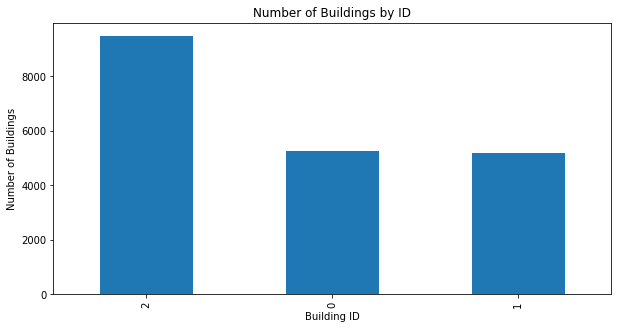

In [9]:
#More observations in building #2
training.BUILDINGID.value_counts(ascending=False).plot(kind='bar', figsize=(10,5))
plt.title('Number of Buildings by ID')
plt.ylabel('Number of Buildings')
plt.xlabel('Building ID')

In [10]:
# Extract buildingid and floor info
building_id_floor = training.groupby(['BUILDINGID', 'FLOOR']).count().reset_index()
building_id_floor['BUILDINGID_FLOOR'] = building_id_floor['BUILDINGID'].apply(str) + "-" + building_id_floor['FLOOR'].apply(str) 
building_id_floor


,BUILDINGID,FLOOR,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,...,WAP519,WAP520,LONGITUDE,LATITUDE,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,BUILDINGID_FLOOR
0,0,0,1059,1059,1059,1059,1059,1059,1059,1059,...,1059,1059,1059,1059,1059,1059,1059,1059,1059,0-0
1,0,1,1356,1356,1356,1356,1356,1356,1356,1356,...,1356,1356,1356,1356,1356,1356,1356,1356,1356,0-1
2,0,2,1443,1443,1443,1443,1443,1443,1443,1443,...,1443,1443,1443,1443,1443,1443,1443,1443,1443,0-2
3,0,3,1391,1391,1391,1391,1391,1391,1391,1391,...,1391,1391,1391,1391,1391,1391,1391,1391,1391,0-3
4,1,0,1368,1368,1368,1368,1368,1368,1368,1368,...,1368,1368,1368,1368,1368,1368,1368,1368,1368,1-0
5,1,1,1484,1484,1484,1484,1484,1484,1484,1484,...,1484,1484,1484,1484,1484,1484,1484,1484,1484,1-1
6,1,2,1396,1396,1396,1396,1396,1396,1396,1396,...,1396,1396,1396,1396,1396,1396,1396,1396,1396,1-2
7,1,3,948,948,948,948,948,948,948,948,...,948,948,948,948,948,948,948,948,948,1-3
8,2,0,1942,1942,1942,1942,1942,1942,1942,1942,...,1942,1942,1942,1942,1942,1942,1942,1942,1942,2-0
9,2,1,2162,2162,2162,2162,2162,2162,2162,2162,...,2162,2162,2162,2162,2162,2162,2162,2162,2162,2-1


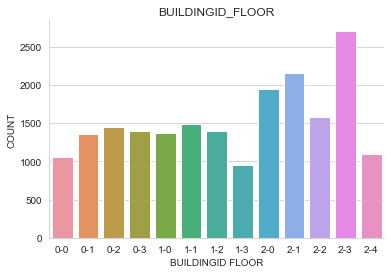

In [11]:
#Dataset becomes more unbalanced when we combine BuildingID and Floor. 
sns.set_style('whitegrid')
sns.barplot(x='BUILDINGID_FLOOR',y='PHONEID', data=building_id_floor)
plt.title('BUILDINGID_FLOOR')
plt.xlabel('BUILDINGID FLOOR')
plt.ylabel('COUNT')
sns.despine()
plt.show()

In [12]:
# Extract buildingid and floor info
building_id_floor_spaceid = training.groupby(['BUILDINGID', 'FLOOR', 'SPACEID']).count().reset_index()
building_id_floor_spaceid['BUILDINGID_FLOOR_SPACEID'] = building_id_floor_spaceid['BUILDINGID'].apply(str) + "-" + building_id_floor_spaceid['FLOOR'].apply(str) + "-" + building_id_floor_spaceid['SPACEID'].apply(str) 
building_id_floor_spaceid

,BUILDINGID,FLOOR,SPACEID,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,...,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,BUILDINGID_FLOOR_SPACEID
0,0,0,102,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,0-0-102
1,0,0,106,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-106
2,0,0,107,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-107
3,0,0,110,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-110
4,0,0,111,20,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,0-0-111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,2,4,216,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-216
731,2,4,217,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-217
732,2,4,218,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-218
733,2,4,219,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-219


In [13]:
# Extract buildingid and floor info
building_id_floor_spaceid_relativeposition = training.groupby(['BUILDINGID', 'FLOOR', 'SPACEID', 'RELATIVEPOSITION']).count().reset_index()
building_id_floor_spaceid_relativeposition['BUILDINGID_FLOOR_SPACEID_RELATIVEPOSITION'] = building_id_floor_spaceid_relativeposition['BUILDINGID'].apply(str) + "-" + building_id_floor_spaceid_relativeposition['FLOOR'].apply(str) + "-" + building_id_floor_spaceid_relativeposition['SPACEID'].apply(str) + "-" + building_id_floor_spaceid_relativeposition['RELATIVEPOSITION'].apply(str)
building_id_floor_spaceid_relativeposition

,BUILDINGID,FLOOR,SPACEID,RELATIVEPOSITION,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,...,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,USERID,PHONEID,TIMESTAMP,BUILDINGID_FLOOR_SPACEID_RELATIVEPOSITION
0,0,0,102,2,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,0-0-102-2
1,0,0,106,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-106-2
2,0,0,107,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-107-2
3,0,0,110,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,0-0-110-2
4,0,0,111,2,20,20,20,20,20,20,...,20,20,20,20,20,20,20,20,20,0-0-111-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,2,4,216,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-216-2
901,2,4,217,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-217-2
902,2,4,218,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-218-2
903,2,4,219,2,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,2-4-219-2


In [14]:
#Explore Longitude and Latitude
coords = training[['LONGITUDE', 'LATITUDE', 'BUILDINGID']]
coords.head()

,LONGITUDE,LATITUDE,BUILDINGID
0,-7541.2643,4.864921e+06,1
1,-7536.6212,4.864934e+06,1
2,-7519.1524,4.864950e+06,1
3,-7524.5704,4.864934e+06,1
4,-7632.1436,4.864982e+06,0


In [15]:
#Set boundries for Long and Lat
BBox = ((coords.LONGITUDE.min(),   coords.LONGITUDE.max(),      
         coords.LATITUDE.min(), coords.LATITUDE.max()))
print(BBox)

(-7691.338399998844, -7300.818990092725, 4864745.745015971, 4865016.687799999)


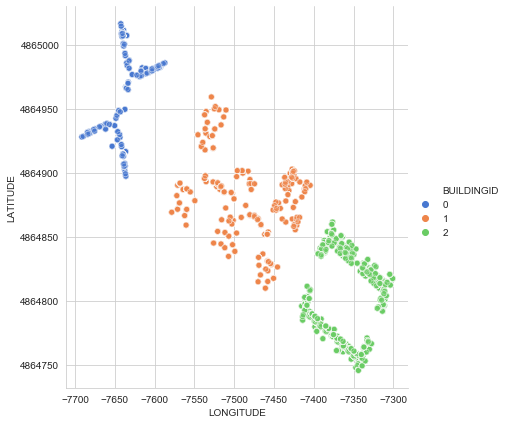

In [16]:
#Plot Long and Lat. Looks like a campus. 
sns.relplot(x='LONGITUDE', y='LATITUDE', sizes=(40, 400), hue= 'BUILDINGID', alpha=.5, palette="muted", height=6, data=coords)

3. Preparing the Data

In [17]:
#Using only Building 0 to save computing time.
training0=training[training.BUILDINGID == 0]
validation0=validation[validation.BUILDINGID == 0]

In [18]:
# 1 Create a unique ID variable that combines FLOOR and SPACEID
training0['unique_id'] = training0.FLOOR.astype(str) + '_' + training0.SPACEID.astype(str) 
validation0['unique_id'] = validation0.FLOOR.astype(str) + '_' + validation0.SPACEID.astype(str) 

C:\Users\jharp\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jharp\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
#Data is unbalanced
training0['unique_id'].value_counts()

0_120    42
2_214    30
1_106    30
1_205    30
0_133    30
         ..
0_226    10
1_127    10
1_212    10
1_227    10
0_107    10
Name: unique_id, Length: 256, dtype: int64

In [20]:
training0['unique_id'].unique()

array(['0_122', '0_102', '0_110', '0_111', '0_107', '0_106', '0_115',
       '0_114', '0_113', '0_112', '0_116', '0_120', '0_119', '0_117',
       '0_118', '0_121', '0_123', '0_125', '0_126', '0_129', '0_127',
       '0_128', '0_133', '0_131', '0_130', '0_134', '0_132', '0_236',
       '0_201', '0_208', '0_202', '0_212', '0_214', '0_209', '0_211',
       '0_213', '0_237', '0_216', '0_215', '0_218', '0_234', '0_220',
       '0_219', '0_235', '0_233', '0_231', '0_232', '0_230', '0_222',
       '2_214', '0_225', '0_229', '0_227', '0_224', '1_211', '1_210',
       '1_209', '1_208', '1_205', '1_206', '1_204', '1_207', '1_203',
       '1_202', '1_201', '1_235', '1_213', '1_215', '1_214', '1_234',
       '1_217', '1_216', '1_218', '1_219', '1_225', '1_220', '1_224',
       '1_221', '1_226', '1_230', '1_233', '1_222', '1_223', '1_228',
       '1_130', '1_138', '1_128', '1_229', '1_116', '1_117', '1_115',
       '1_118', '1_121', '1_120', '1_126', '1_119', '1_125', '1_122',
       '1_101', '1_1

In [21]:
training.shape

(19937, 529)

In [22]:
#Classify dependent and independent variables
X = training0.iloc[:,0:519]
Y = training0['unique_id']
print(X.shape, Y.shape)

(5249, 519) (5249,)


In [25]:
#Create Train and Test data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=21, stratify=Y)

In [28]:
#Use Smote to create synthetic samples of the minority classes to deal with unbalanced data
sm = SMOTE()
X_train_sm, Y_train_sm = sm.fit_sample(X_train, Y_train)
print(X_train_sm.shape, Y_train_sm.shape)

(8704, 519) (8704,)


In [29]:
#Scale the varaibles
sc = StandardScaler()
X_train_sm = sc.fit_transform(X_train_sm)
X_test_sm = sc.transform(X_test)

In [30]:
#Keep the variables that add up to 95% of explained variance. Reduces explanatory variables from 519 to 145. Save computing time. 
pca = PCA(0.95)
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca = pca.transform(X_test_sm)
print(X_train_pca.shape)

(8704, 145)


In [31]:
#Show the Explained Variance for kept variables. 
pca.explained_variance_ratio_

array([0.08629811, 0.03963626, 0.02734292, 0.02590056, 0.02358869,
       0.01951099, 0.01708727, 0.01640291, 0.01558018, 0.0151587 ,
       0.01377848, 0.01337575, 0.01233774, 0.0118728 , 0.01116387,
       0.01084868, 0.01050249, 0.01048409, 0.01007215, 0.00992706,
       0.00988718, 0.00957192, 0.00917671, 0.00897869, 0.0086616 ,
       0.00847084, 0.00827777, 0.00816017, 0.00810454, 0.00795454,
       0.00782089, 0.00764511, 0.00755706, 0.00743132, 0.00720141,
       0.0070942 , 0.00703184, 0.00694413, 0.00686617, 0.00676915,
       0.00658434, 0.0064913 , 0.00641049, 0.00631601, 0.00617352,
       0.00613211, 0.00598152, 0.00586364, 0.00572629, 0.00569863,
       0.00560122, 0.00550612, 0.00544313, 0.00530614, 0.00526452,
       0.00525333, 0.00520733, 0.00517015, 0.00515016, 0.0051242 ,
       0.00511339, 0.00509036, 0.00507338, 0.005014  , 0.00500428,
       0.00497089, 0.00493385, 0.00489896, 0.00488029, 0.0048641 ,
       0.00484191, 0.00477956, 0.00467788, 0.00461179, 0.00458

Evaluate Algorithms/Improve Results (Hypertuning)

Random Forest

In [32]:
rf_base = RandomForestClassifier(random_state=42)

In [33]:
# Train the model on training data
rf_base.fit(X_train_sm, Y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [34]:
# Predicting the Test set results
Y_pred_rf_base = rf_base.predict(X_test_sm)

In [38]:
print('Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_rf_base)))

Accuracy 0.7628571428571429


In [39]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf_base.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [40]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features}

pprint(random_grid)

{'max_features': ['auto', 'sqrt'], 'n_estimators': [100, 200, 300, 400, 500]}


In [41]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf_random = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_sm, Y_train_sm)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  3.9min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [42]:
rf_random.best_params_

{'n_estimators': 400, 'max_features': 'sqrt'}

In [43]:
rf_tune = RandomForestClassifier(n_estimators= 400, max_features= 'sqrt', random_state=42)

In [44]:
# Train the model on training data
rf_tune.fit(X_train_sm, Y_train_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [45]:
# Predicting the Test set results
Y_pred_rf_tune = rf_tune.predict(X_test_sm)

In [46]:
print('Base Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_rf_base)))
print('Tuned Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_rf_tune)))

Base Accuracy 0.7628571428571429
Tuned Accuracy 0.7771428571428571


Logistic Regression

In [47]:
lr_base = LogisticRegression(random_state=42)

In [48]:
# Train the model on training data
lr_base.fit(X_train_sm, Y_train_sm)

C:\Users\jharp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [49]:
# Predicting the Test set results
Y_pred_lr_base = lr_base.predict(X_test_sm)

In [50]:
print('Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_lr_base)))

Accuracy 0.580952380952381


In [51]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(lr_base.get_params())

Parameters currently in use:

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


In [52]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values = [10, 1.0, 0.1]
# Create the random grid
random_grid = {'solver': solvers, 'C': c_values}

pprint(random_grid)

{'C': [10, 1.0, 0.1], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}


In [53]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lr_random = LogisticRegression(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lr_random = RandomizedSearchCV(estimator = lr_base, param_distributions = random_grid, n_iter = 3, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
lr_random.fit(X_train_sm, Y_train_sm)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.2min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  3.1min finished
C:\Users\jharp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LogisticRegression(C=1.0, class_weight=None,
                                                dual=False, fit_intercept=True,
                                                intercept_scaling=1,
                                                l1_ratio=None, max_iter=100,
                                                multi_class='auto', n_jobs=None,
                                                penalty='l2', random_state=42,
                                                solver='lbfgs', tol=0.0001,
                                                verbose=0, warm_start=False),
                   iid='deprecated', n_iter=3, n_jobs=-1,
                   param_distributions={'C': [10, 1.0, 0.1],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
             

In [54]:
lr_random.best_params_

{'solver': 'lbfgs', 'C': 10}

In [55]:
lr_tune = LogisticRegression(random_state=42, solver='lbfgs', C = 10)

In [56]:
lr_tune.fit(X_train_sm, Y_train_sm)

C:\Users\jharp\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [57]:
# Predicting the Test set results
Y_pred_lr_tune = lr_tune.predict(X_test_sm)

In [58]:
print('LR Base Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_lr_base)))
print('LR Tune Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_lr_tune)))

LR Base Accuracy 0.580952380952381
LR Tune Accuracy 0.5742857142857143


KNN

In [59]:
knn_base = KNeighborsClassifier()

In [60]:
# Train the model on training data
knn_base.fit(X_train_sm, Y_train_sm)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [61]:
# Predicting the Test set results
Y_pred_knn_base = knn_base.predict(X_test_sm)

In [62]:
print('Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_knn_base)))

Accuracy 0.5295238095238095


In [63]:
#List Hyperparameters that we want to tune.
n_neighbors = list(range(1,30))
random_grid = {'n_neighbors': n_neighbors}

In [64]:
# search across 100 different combinations, and use all available cores
knn_random = RandomizedSearchCV(estimator = knn_base, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
knn_random.fit(X_train_sm, Y_train_sm)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='deprecated', n_iter=10, n_jobs=-1,
                   param_distributions={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29]},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
            

In [65]:
knn_random.best_params_

{'n_neighbors': 1}

In [66]:
knn_tune = KNeighborsClassifier(n_neighbors=1)

In [67]:
# Train the model on training data
knn_tune.fit(X_train_sm, Y_train_sm)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [68]:
# Predicting the Test set results
Y_pred_knn_tune = knn_tune.predict(X_test_sm)

In [69]:
print('KNN Base Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_knn_base)))
print('KNN Tune Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_knn_tune)))

KNN Base Accuracy 0.5295238095238095
KNN Tune Accuracy 0.5666666666666667


Light Gradient Boosting Machine

In [70]:
lgbm_base = LGBMClassifier(n_estimators=2000, feature_fraction=0.06, bagging_fraction=0.67, bagging_freq=1,verbose=0, n_jobs=-1, random_state=42)

In [71]:
# Train the model on training data
lgbm_base.fit(X_train_sm, Y_train_sm)

LGBMClassifier(bagging_fraction=0.67, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.06,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [72]:
# Predicting the Test set results
Y_pred_lgbm_base = lgbm_base.predict(X_test_sm)

In [73]:
print('Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_lgbm_base)))

Accuracy 0.7866666666666666


In [74]:
boosting_type = ['gbdt', 'dart', 'goss']
learning_rate = [0.05, 0.1, 0.2]
# Create the random grid
random_grid = {'boosting_type': boosting_type, 'learning_rate': learning_rate}

pprint(random_grid)

{'boosting_type': ['gbdt', 'dart', 'goss'], 'learning_rate': [0.05, 0.1, 0.2]}


In [75]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
lgbm_random = LGBMClassifier(random_state=42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
lgbm_random = RandomizedSearchCV(estimator = lgbm_random, param_distributions = random_grid, n_iter = 6, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
lgbm_random.fit(X_train_sm, Y_train_sm)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  5.6min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  8.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_for_bin=2

In [76]:
lgbm_random.best_params_

{'learning_rate': 0.05, 'boosting_type': 'gbdt'}

In [77]:
lgbm_tune = LGBMClassifier(n_estimators=2000, feature_fraction=0.06, bagging_fraction=0.67, bagging_freq=1,verbose=0, n_jobs=-1, random_state=42, learning_rate=0.05, boosting_type='gbdt')

In [78]:
# Train the model on training data
lgbm_tune.fit(X_train_sm, Y_train_sm)

LGBMClassifier(bagging_fraction=0.67, bagging_freq=1, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.06,
               importance_type='split', learning_rate=0.05, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=2000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [79]:
# Predicting the Test set results
Y_pred_lgbm_tune = lgbm_tune.predict(X_test_sm)

In [80]:
print('Accuracy' + " " + str(accuracy_score(Y_test, Y_pred_lgbm_tune)))

Accuracy 0.8038095238095239


Best model: While a tuned Random Forest can get us 77.4% accuracy, the best model was a tuned Light Gradient Boosting Machine. 

Areas of Improvement: 
1. Increased computing power will enable us to be more robust in our tuning. 
2. Increased data, paticularly in low traffic areas, can also increase accuracy. 
3. As we get more data, we can add relative position to our unique ID